In [19]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from osgeo import gdal
import geopandas as gpd
import torch
import os
import sys

In [32]:
sys.path.append('../src/')

In [33]:
from utils.data_loader import SatelliteImageDataset

In [34]:
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch CUDA available: True
GPU: NVIDIA GeForce RTX 5070 Laptop GPU


In [36]:
DATA_DIR = "../data/raw/sentinal2"

In [37]:
if os.path.exists(DATA_DIR):
    files = os.listdir(DATA_DIR)
    print(f"Found {len(files)} satellite images:")
    for f in sorted(files)[:5]:  # Show first 5
        print(f"  {f}")
else:
    print("Data directory not found - download files from Google Drive first")

Found 24 satellite images:
  S2_Yamuna_2023_01.tif
  S2_Yamuna_2023_02.tif
  S2_Yamuna_2023_03.tif
  S2_Yamuna_2023_04.tif
  S2_Yamuna_2023_05.tif


In [38]:
# Comprehensive data analysis
print("=== SATELLITE DATA QUALITY REPORT ===")

# Analyze all downloaded files
file_sizes = []
band_counts = []
spatial_refs = []

for file in sorted(files):
    file_path = os.path.join(DATA_DIR, file)
    with rasterio.open(file_path) as src:
        file_sizes.append(os.path.getsize(file_path) / (1024*1024))  # MB
        band_counts.append(src.count)
        spatial_refs.append(str(src.crs))
        
        print(f"\n📁 {file}:")
        print(f"   Size: {file_sizes[-1]:.1f} MB")
        print(f"   Bands: {band_counts[-1]}")
        print(f"   CRS: {spatial_refs[-1]}")
        print(f"   Shape: {src.height} x {src.width}")
        print(f"   Bounds: {src.bounds}")

print(f"\n📊 SUMMARY:")
print(f"Total files: {len(files)}")
print(f"Average size: {np.mean(file_sizes):.1f} MB")
print(f"Unique CRS: {len(set(spatial_refs))}")
print(f"Band consistency: {len(set(band_counts)) == 1}")

=== SATELLITE DATA QUALITY REPORT ===

📁 S2_Yamuna_2023_01.tif:
   Size: 29.8 MB
   Bands: 6
   CRS: EPSG:4326
   Shape: 1114 x 1114
   Bounds: BoundingBox(left=77.2999403669564, bottom=28.49995070397594, right=77.40001268960732, top=28.600023026626854)

📁 S2_Yamuna_2023_02.tif:
   Size: 30.2 MB
   Bands: 6
   CRS: EPSG:4326
   Shape: 1114 x 1114
   Bounds: BoundingBox(left=77.2999403669564, bottom=28.49995070397594, right=77.40001268960732, top=28.600023026626854)

📁 S2_Yamuna_2023_03.tif:
   Size: 30.4 MB
   Bands: 6
   CRS: EPSG:4326
   Shape: 1114 x 1114
   Bounds: BoundingBox(left=77.2999403669564, bottom=28.49995070397594, right=77.40001268960732, top=28.600023026626854)

📁 S2_Yamuna_2023_04.tif:
   Size: 30.2 MB
   Bands: 6
   CRS: EPSG:4326
   Shape: 1114 x 1114
   Bounds: BoundingBox(left=77.2999403669564, bottom=28.49995070397594, right=77.40001268960732, top=28.600023026626854)

📁 S2_Yamuna_2023_05.tif:
   Size: 30.4 MB
   Bands: 6
   CRS: EPSG:4326
   Shape: 1114 x 1114
   

✅ Dataset initialized with 24 images

🧪 Testing with first image:


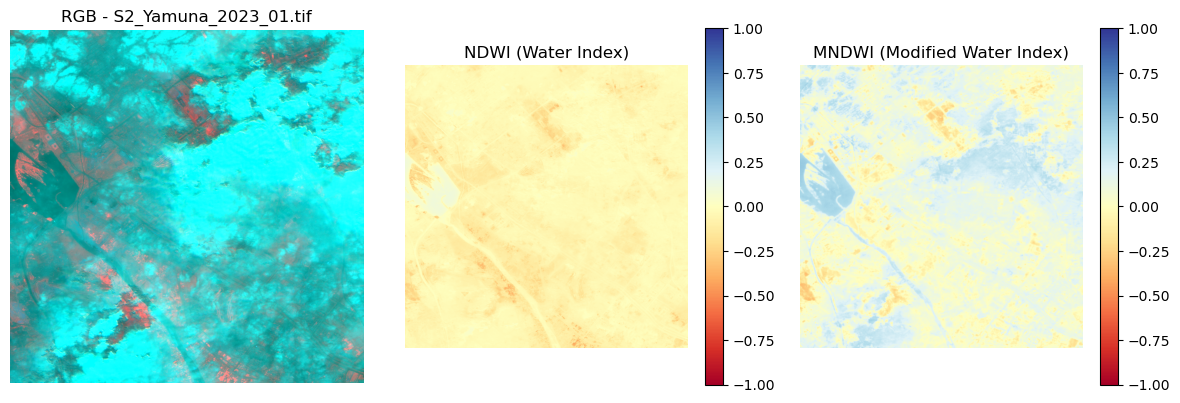


🔄 Comparing temporal changes...


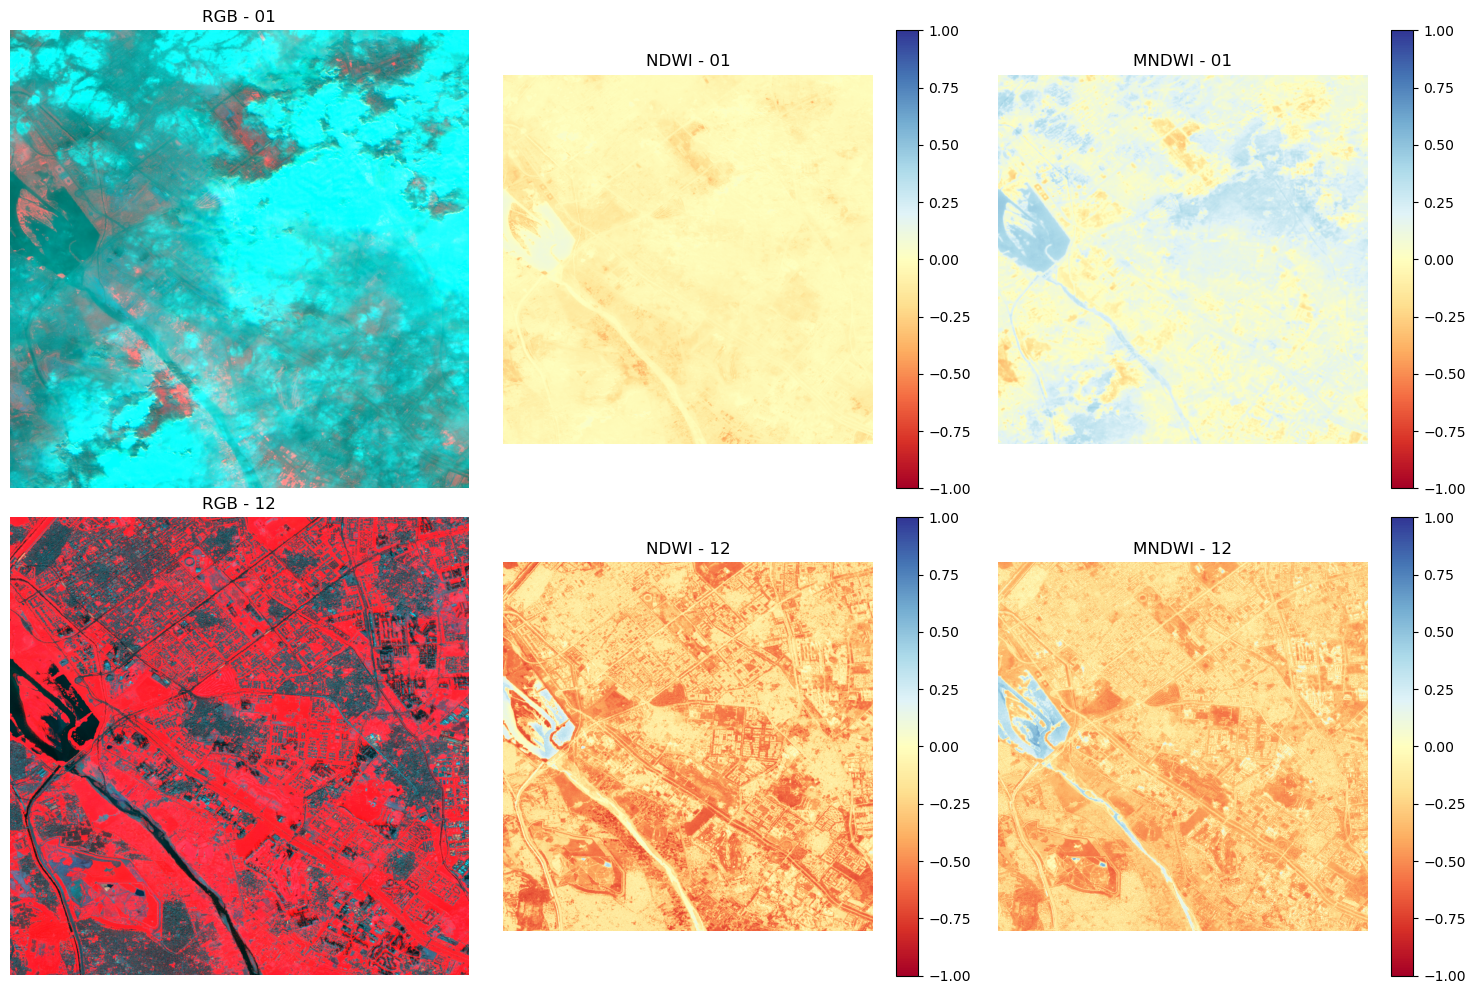

In [39]:
# Initialize the dataset FIRST
dataset = SatelliteImageDataset(DATA_DIR)
print(f"✅ Dataset initialized with {len(dataset)} images")

# Test with a single sample first
print("\n🧪 Testing with first image:")
dataset.visualize_sample(0)

# NOW run temporal comparison
if len(dataset) >= 2:
    print("\n🔄 Comparing temporal changes...")
    plot_temporal_comparison(0, -1)  # First vs last month
else:
    print("❌ Need at least 2 images for temporal comparison")

🔄 Comparing temporal changes...


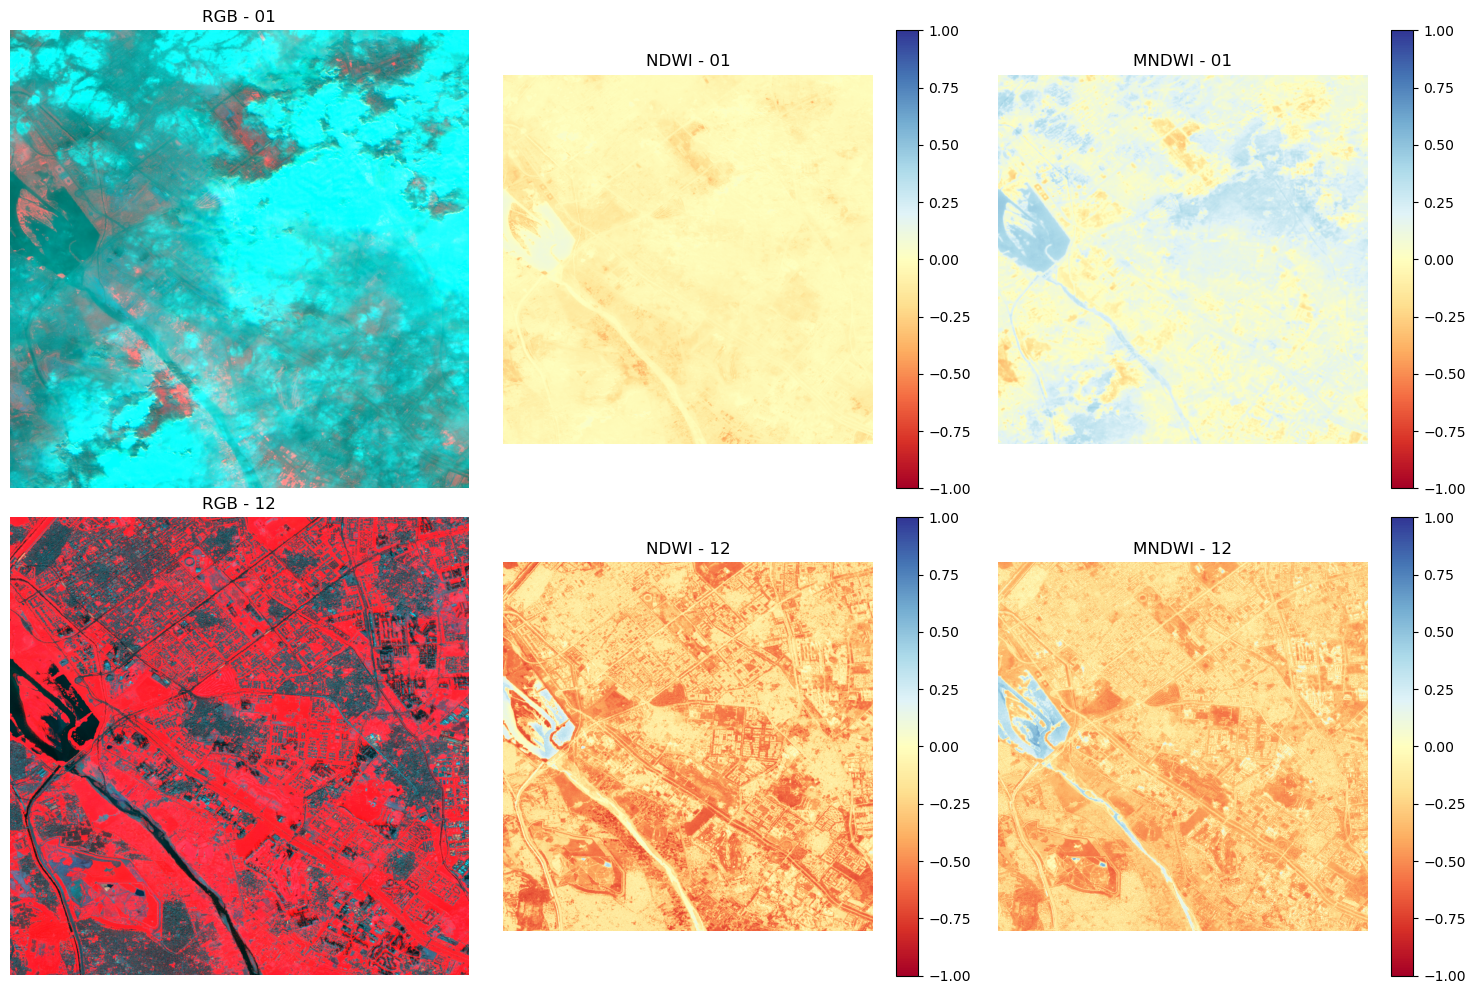

In [40]:
# Temporal analysis - compare different months
def plot_temporal_comparison(month1_idx, month2_idx):
    """Compare two different time periods"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for i, idx in enumerate([month1_idx, month2_idx]):
        image, metadata = dataset[idx]
        filename = metadata['filename']
        
        # Extract year and month from filename
        year_month = filename.split('_')[-1].replace('.tif', '')
        
        # RGB
        rgb = np.stack([image[3], image[2], image[1]], axis=-1)  # B4, B3, B2
        rgb = np.clip(rgb * 3, 0, 1)
        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title(f"RGB - {year_month}")
        axes[i, 0].axis('off')
        
        # NDWI
        ndwi = image[4]  # Band 4 should be NDWI
        im = axes[i, 1].imshow(ndwi, cmap='RdYlBu', vmin=-1, vmax=1)
        axes[i, 1].set_title(f"NDWI - {year_month}")
        axes[i, 1].axis('off')
        plt.colorbar(im, ax=axes[i, 1])
        
        # MNDWI
        mndwi = image[5]  # Band 5 should be MNDWI
        im = axes[i, 2].imshow(mndwi, cmap='RdYlBu', vmin=-1, vmax=1)
        axes[i, 2].set_title(f"MNDWI - {year_month}")
        axes[i, 2].axis('off')
        plt.colorbar(im, ax=axes[i, 2])
    
    plt.tight_layout()
    plt.show()

# Compare first and last available months
if len(dataset) >= 2:
    print("🔄 Comparing temporal changes...")
    plot_temporal_comparison(0, -1)  # First vs last month